# Decision Tree


In [5]:
import os
import pandas as pd 
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import json
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, roc_auc_score, auc, recall_score, f1_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [6]:
df = pd.read_csv("lead_data_expanded.csv")
df.columns


Index(['School_District', 'School', 'County', 'num_lte_5ppb', 'num_gt_5ppb',
       'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races', 'target_col',
       'percent_housing_pre_1950'],
      dtype='object')

In [7]:
df_copied = df.copy()

### Train test split

In [8]:
X = df_copied.drop(columns=['target_col','num_gt_5ppb','School','num_lte_5ppb','County'])

y = df_copied['target_col']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40, stratify=y,)

### Pipeline

In [10]:
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [11]:
num_transformer = Pipeline([('imputer',SimpleImputer(strategy='median')), ('scaler',StandardScaler())])
cat_transformer = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num',num_transformer,num_features),('cat', cat_transformer,cat_features)])

## Baseline

In [12]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train,y_train,test_size=0.2,random_state=40, stratify=y_train,)

In [13]:
clf = Pipeline([ ('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier()) ])
clf.fit(X_train_t,y_train_t)
y_pred_base = clf.predict(X_test_t)

print("Classification report:\n",classification_report(y_test_t,y_pred_base))


Classification report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.70       254
           1       0.65      0.64      0.64       215

    accuracy                           0.68       469
   macro avg       0.67      0.67      0.67       469
weighted avg       0.68      0.68      0.68       469



## Decision tree with hyperparameter tuning

In [14]:
from sklearn.model_selection import StratifiedKFold

In [15]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=40)

### Based on ROC-AUC

In [16]:
rng = np.random.default_rng(seed=40)

In [17]:
parameters = { 'classifier__max_depth' : rng.integers(1,10,size=10).tolist(),
              'classifier__min_samples_split' : rng.integers(2,20,size=10).tolist(),
              'classifier__max_leaf_nodes' : rng.integers(2,20,size=10).tolist()
              }

outer_scores = []
best_params_list = []
roc_curves = []

metrics = {'f1': f1_score, 'recall': recall_score, 'accuracy': accuracy_score, 'roc_auc': roc_auc_score}

# Store results
outer_results = {metric: [] for metric in metrics}



In [18]:


for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Inner CV 
    random_search = RandomizedSearchCV(estimator=clf, param_distributions=parameters,n_iter=200,
                                        cv=inner_cv, random_state=40,scoring='roc_auc', n_jobs=-1)
    random_search.fit(X_tr, y_tr)

    best_model = random_search.best_estimator_

        
    y_pred = best_model.predict(X_te)
    y_proba = best_model.predict_proba(X_te)[:, 1]

   
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr,tpr))

    # Metrics
    for metric_name, func in metrics.items():
        if metric_name == 'roc_auc':
            outer_results[metric_name].append(func(y_te, y_proba))
        else:
            outer_results[metric_name].append(func(y_te, y_pred))
    
    print(f"Fold {fold} : Best params: {random_search.best_params_} : F1: {outer_results['f1'][-1]:.4f} : Recall: {outer_results['recall'][-1]:.4f} : Accuracy: {outer_results['accuracy'][-1]:.4f} : ROC-AUC: {outer_results['roc_auc'][-1]:.4f}")






Fold 1 : Best params: {'classifier__min_samples_split': 3, 'classifier__max_leaf_nodes': 11, 'classifier__max_depth': 5} : F1: 0.6667 : Recall: 0.6589 : Accuracy: 0.6994 : ROC-AUC: 0.7155
Fold 2 : Best params: {'classifier__min_samples_split': 18, 'classifier__max_leaf_nodes': 13, 'classifier__max_depth': 6} : F1: 0.6545 : Recall: 0.6698 : Accuracy: 0.6759 : ROC-AUC: 0.7207
Fold 3 : Best params: {'classifier__min_samples_split': 12, 'classifier__max_leaf_nodes': 16, 'classifier__max_depth': 7} : F1: 0.6603 : Recall: 0.6419 : Accuracy: 0.6972 : ROC-AUC: 0.7022
Fold 4 : Best params: {'classifier__min_samples_split': 3, 'classifier__max_leaf_nodes': 19, 'classifier__max_depth': 6} : F1: 0.6744 : Recall: 0.6822 : Accuracy: 0.6987 : ROC-AUC: 0.7230
Fold 5 : Best params: {'classifier__min_samples_split': 3, 'classifier__max_leaf_nodes': 5, 'classifier__max_depth': 6} : F1: 0.6569 : Recall: 0.6308 : Accuracy: 0.6987 : ROC-AUC: 0.6976



Mean performance across outer folds:
f1: 0.6626 ± 0.0072
recall: 0.6567 ± 0.0185
accuracy: 0.6940 ± 0.0091
roc_auc: 0.7118 ± 0.0101


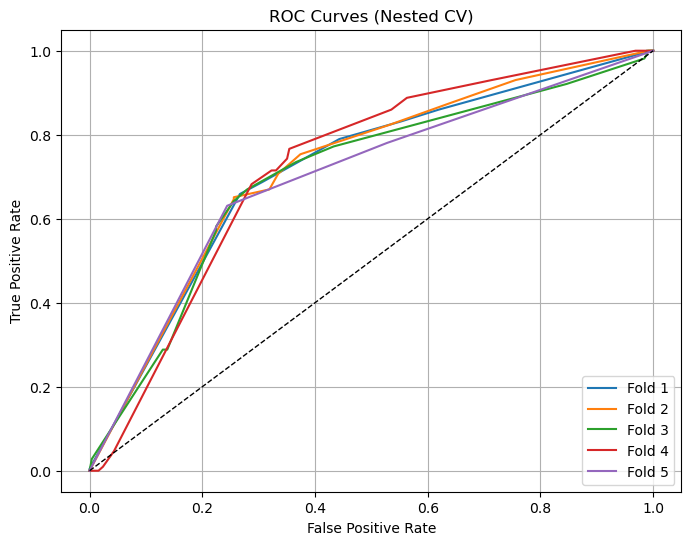

In [19]:
print("\nMean performance across outer folds:")
for metric_name, scores in outer_results.items():
    print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

plt.figure(figsize=(8,6))
for i, (fpr, tpr) in enumerate(roc_curves, 1):
    plt.plot(fpr, tpr, label=f'Fold {i}')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Nested CV)')
plt.legend(loc='lower right')
plt.grid()
plt.show()